# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

## <font color='blue'>Lab 5</font>

## <font color='blue'>Machine Learning com PySpark</font>

Leia os manuais em pdf no Capítulo 14 do curso com o material complementar.

![title](imagens/Lab5.png)

## <font color='blue'>Clusterização (Agrupamento)</font>

Aqui o nosso objetivo será agrupar veículos por similaridade, ou seja, criar grupos de veículos similares. Não temos essa informação previamente e por isso aprendizado supervisionado não pode ser usado. Usaremos um algoritmo de aprendizado não supervisionado, entregando ao algoritmo somente os dados de entrada.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
#!pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [4]:
# Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

findspark : 2.0.1
pyspark   : 3.3.0
pandas    : 1.3.4
matplotlib: 3.4.3



## Carregando os Dados

In [6]:
# Criando o Spark Context
sc = SparkContext(appName = "Lab5")

22/08/24 17:54:33 WARN Utils: Your hostname, falcon.local resolves to a loopback address: 127.0.0.1; using 10.0.0.87 instead (on interface en0)
22/08/24 17:54:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/24 17:54:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/24 17:54:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/24 17:54:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/24 17:54:35 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/08/24 17:54:35 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [7]:
sc.setLogLevel("ERROR")

In [8]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").getOrCreate()

In [9]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("dados/dataset5.csv")
carrosRDD.cache()

dados/dataset5.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [10]:
carrosRDD.count()

198

In [11]:
carrosRDD.take(5)

['fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

In [12]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [13]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

## Pré-Processamento dos Dados

In [14]:
# Convertendo e limpando os dados
def transformToNumeric(inputStr) :
    
    # Divide a linha em colunas
    attList = inputStr.split(",")

    # Aplica label encoding para as colunas de índice 3 e 4
    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    # Usaremos somente algumas variáveis do conjunto de dados original
    linhas = Row(DOORS = doors, 
                 BODY = float(body), 
                 HP = float(attList[7]), 
                 RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

In [15]:
# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

In [16]:
# Criando um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



## Padronização

Os dados estão em escalas diferentes (dezena, centena, etc...). Para o funcionamento correto do algoritmo os dados devem estar na mesma escala e por isso aplicaremos a padronização.

In [17]:
# Sumarizando os dados e extraindo a média e o desvio padrão
estats = carrosDF.describe().toPandas()
estats

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359884,37.63920534951835,481.03591405011446,6.437862917085912
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [18]:
# Extraindo a média e o desvio padrão
medias = estats.iloc[1,1:6].values.tolist()
desvios = estats.iloc[2,1:6].values.tolist()

In [19]:
print(medias)

['1.5685279187817258', '1.532994923857868', '103.60406091370558', '5118.0203045685275', '25.15228426395939']


In [20]:
print(desvios)

['0.49654352778167493', '0.5001812579359884', '37.63920534951835', '481.03591405011446', '6.437862917085912']


In [21]:
# Colocando a média e o desvio padrão em variáves do tipo Broadcast (disponíveis em todo o cluster)
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [22]:
# Função para centralizar e aplicar escala aos dados, gerando um vetor de saída 
# Cada valor será subtraído da média e então dividido pelo desvio padrão.
def centerAndScale(inRow):
    
    # Variáveis globais
    global bc_media
    global bc_desvio
    
    # Array de médias e desvios
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    # Array para o resultado
    retArray = []
    
    # Loop para o cálculo
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
        
    return Vectors.dense(retArray)

In [23]:
# Aplica a função
carrosRDD4 = carrosDF.rdd.map(centerAndScale)

In [24]:
carrosRDD4.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532, 0.9083]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375, 3.3936]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.753]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 1.5297]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941, 1.9956]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862, 1.9956]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611, 3.7043]),
 DenseVector([0.869, 0.933

In [25]:
# Criando um Dataframe
carrosRDD5 = carrosRDD4.map(lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(15)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[0.86895117361793...|
|[0.86895117361793...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 15 rows



## Machine Learning

In [26]:
# Criando o modelo
kmeans = KMeans(k = 3, seed = 1)

In [27]:
# Treina o modelo
modelo = kmeans.fit(carrosDF)

In [28]:
# Previsões
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[0.86895117361793...|         1|
|[0.86895117361793...|         1|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[0.86895117361793...|         1|
|[-1.1449709581789...|         2|
|[0.86895117361793...|         1|
+--------------------+----------+
only showing top 20 rows



In [29]:
# Função para extrair os atributos das previsões
def unstripData(instr) :
    return (instr["prediction"], 
            instr["features"][0], 
            instr["features"][1], 
            instr["features"][2], 
            instr["features"][3],
            instr["features"][4])

In [30]:
# Aplica a função nas previsões
carrosRDD6 = previsoes.rdd.map(unstripData)

In [31]:
predList = carrosRDD6.collect()

In [32]:
# Converte em DataFrame do Pandas
predPd = pd.DataFrame(predList)

In [33]:
predPd.head(20)

,0,1,2,3,4,5
0,2,-1.144971,0.933672,-0.919362,-0.453231,0.908332
1,2,-1.144971,0.933672,-1.477291,-0.037461,3.393629
2,2,-1.144971,0.933672,-0.945930,-0.245346,0.753001
3,2,-1.144971,0.933672,-1.105338,-0.661116,1.529656
4,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
5,2,-1.144971,0.933672,-1.158475,0.794077,1.995649
6,2,-1.144971,-1.065604,-0.919362,0.170423,0.908332
7,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
8,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
9,2,-1.144971,0.933672,-0.945930,-0.245346,0.908332


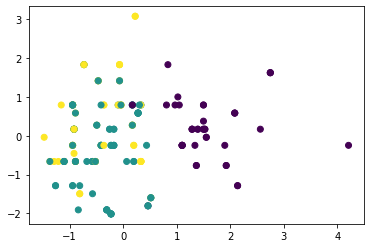

In [34]:
# Gráfico com o resultados dos clusters criados
plt.cla()
plt.scatter(predPd[3], predPd[4], c = predPd[0])

# Fim